In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split

In [2]:
cloud_cat = np.load('cloud_cat.npy')
cloud_apply = np.load('cloud_apply.npy')
cd_rows = 77
os_rows = 72
sample_cloud_num = 100

In [3]:
X_k2 = cloud_cat[:(cd_rows + os_rows)*sample_cloud_num, 4:]
X_kepler = cloud_cat[(cd_rows + os_rows)*sample_cloud_num:, 4:]

y_k2 = cloud_cat[:(cd_rows + os_rows)*sample_cloud_num, [1, 2]]
y_kepler = cloud_cat[(cd_rows + os_rows)*sample_cloud_num:, [1, 2]]

In [4]:
train_frac = 0.7
test_frac = 1.0 - train_frac
X_train_k2, X_test_k2, y_train_k2, y_test_k2 = train_test_split(X_k2, y_k2, train_size=train_frac)
X_train_kep, X_test_kep, y_train_kep, y_test_kep = train_test_split(X_kepler, y_kepler, train_size=train_frac)

X_test = np.append(X_test_k2, X_test_kep, axis=0)
X_train = np.append(X_train_k2, X_train_kep, axis=0)


y_test = np.append(y_test_k2, y_test_kep, axis=0)
y_train = np.append(y_train_k2, y_train_kep, axis=0)

# X_test = X_test_k2
# X_train = X_train_k2

# y_test= y_test_k2
# y_train = y_train_k2

/Users/gmduvvuri/miniconda3/envs/astroconda/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=200, n_jobs=-1,oob_score=True))
regr_multirf.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False),
           n_jobs=1)

In [6]:
y_multirf = regr_multirf.predict(X_test)

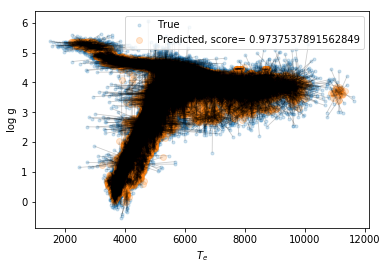

In [7]:
temp_diff = y_test[:, 0] - y_multirf[:, 0]
logg_diff = y_test[:, 1] - y_multirf[:, 1]


plt.scatter(y_test[:, 0], y_test[:, 1], label='True', marker='.', alpha=0.2)
# plt.scatter(y_train[:, 0], y_train[:, 1], label='Train', alpha=0.2)
plt.scatter(y_multirf[:, 0], y_multirf[:, 1], label='Predicted, score= ' + str(regr_multirf.score(X_test, y_test)), alpha=0.2)
plt.quiver(y_test[:, 0], y_test[:, 1], -temp_diff, -logg_diff, angles='xy', scale=1, scale_units='xy', alpha=0.2)
plt.xlabel(r'$T_e$')
plt.ylabel(r'log g')
# plt.ylim(4.0, 5.5)
plt.legend()
plt.savefig('prelim_rf_test.pdf')
plt.show()

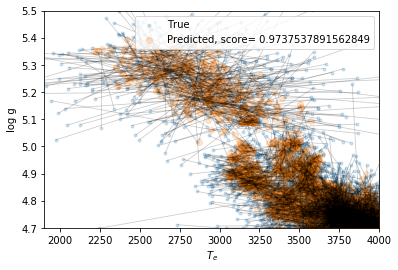

In [8]:
temp_diff = y_test[:, 0] - y_multirf[:, 0]
logg_diff = y_test[:, 1] - y_multirf[:, 1]


plt.scatter(y_test[:, 0], y_test[:, 1], label='True', marker='.', alpha=0.2)
# plt.scatter(y_train[:, 0], y_train[:, 1], label='Train', alpha=0.2)
plt.scatter(y_multirf[:, 0], y_multirf[:, 1], label='Predicted, score= ' + str(regr_multirf.score(X_test, y_test)), alpha=0.2)
plt.quiver(y_test[:, 0], y_test[:, 1], -temp_diff, -logg_diff, angles='xy', scale=1, scale_units='xy', alpha=0.2)
plt.xlabel(r'$T_e$')
plt.ylabel(r'log g')
plt.ylim(4.7, 5.5)
plt.xlim(1900, 4000)
plt.legend()
plt.show()

In [9]:
teff_weight = regr_multirf.estimators_[0].oob_score_

In [10]:
logg_weight = regr_multirf.estimators_[1].oob_score_

In [11]:
predictions_cat = regr_multirf.predict(cloud_cat[:, 4:])
# predictions_apply = regr_multirf.predict(cloud_apply[:, 4:])

In [12]:
means_cat = [np.mean(predictions_cat[i*(sample_cloud_num):(i+1)*sample_cloud_num, :2], axis=0)
             for i in range(0, int(len(cloud_cat)/sample_cloud_num))]
errs_cat = [np.std(predictions_cat[i*(sample_cloud_num):(i+1)*sample_cloud_num, :2], axis=0)
             for i in range(0, int(len(cloud_cat)/sample_cloud_num))]

means_true = [np.mean(cloud_cat[i*(sample_cloud_num):(i+1)*sample_cloud_num, [1, 2]], axis=0)
             for i in range(0, int(len(cloud_cat)/sample_cloud_num))]
errs_true = [np.std(cloud_cat[i*(sample_cloud_num):(i+1)*sample_cloud_num, [1, 2]], axis=0)
             for i in range(0, int(len(cloud_cat)/sample_cloud_num))]

means_cat = np.array(means_cat)
errs_cat = np.array(errs_cat)/np.array([teff_weight, logg_weight])
means_true = np.array(means_true)
errs_true = np.array(errs_true)
temp_diff_2 = means_true[:, 0] - means_cat[:, 0]
logg_diff_2 = means_true[:, 1] - means_true[:, 1]
# mean_apply =  np.mean(predictions_apply, axis=0)
# errs_apply = np.mean(predictions_apply, axis=0)

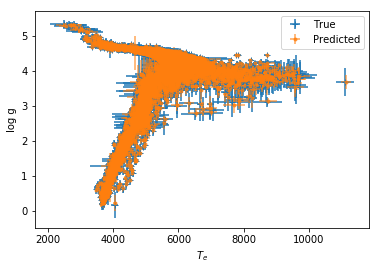

In [13]:
plt.errorbar(x=means_true[:, 0], y=means_true[:, 1], xerr=errs_true[:, 0], yerr=errs_true[:, 1], label='True', fmt='+')
plt.errorbar(x=means_cat[:, 0], y=means_cat[:, 1], xerr=errs_cat[:, 0], yerr=errs_cat[:, 1], label='Predicted', fmt='.', alpha=0.7)
plt.quiver(means_true[:, 0], means_true[:, 1], -temp_diff_2, -logg_diff_2, angles='xy', scale=1, scale_units='xy', alpha=0.2)
plt.legend()
plt.xlabel(r'$T_e$')
plt.ylabel(r'log g')
plt.show()

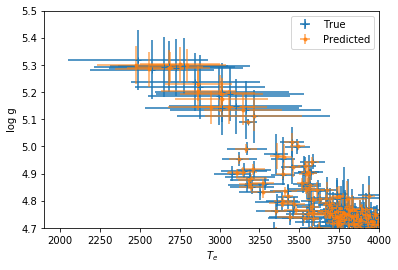

In [14]:
plt.errorbar(x=means_true[:, 0], y=means_true[:, 1], xerr=errs_true[:, 0], yerr=errs_true[:, 1], label='True', fmt='+')
plt.errorbar(x=means_cat[:, 0], y=means_cat[:, 1], xerr=errs_cat[:, 0], yerr=errs_cat[:, 1], label='Predicted', fmt='.', alpha=0.7)
plt.quiver(means_true[:, 0], means_true[:, 1], -temp_diff_2, -logg_diff_2, angles='xy', scale=1, scale_units='xy', alpha=0.2)
plt.legend()
plt.xlabel(r'$T_e$')
plt.ylabel(r'log g')
plt.ylim(4.7, 5.5)
plt.xlim(1900, 4000)
plt.show()

In [ ]:
try_num_low = 0
try_num_high = 100000
predictions_apply = regr_multirf.predict(cloud_apply[:,4:])
means_apply = [np.mean(predictions_apply[i*(sample_cloud_num):(i+1)*sample_cloud_num, :2], axis=0)
             for i in range(0, int(len(cloud_apply)/sample_cloud_num))]
errs_apply = [np.std(predictions_apply[i*(sample_cloud_num):(i+1)*sample_cloud_num, :2], axis=0)
             for i in range(0, int(len(cloud_apply)/sample_cloud_num))]
means_apply = np.array(means_apply)
errs_apply = np.array(errs_apply)

In [ ]:
plt.errorbar(x=means_apply[:, 0], y=means_apply[:, 1], xerr=errs_apply[:, 0], yerr=errs_apply[:, 1], label='Predicted', fmt='.', alpha=0.7)
plt.show()

In [ ]:
np.save('means_apply', means_apply)
np.save('errs_apply', errs_apply)
np.save('means_cat', means_cat)
np.save('errs_cat', errs_cat)

In [ ]:
from sklearn.externals import joblib
joblib.dump(regr_multirf, 'regr_multirf_200.pkl') 